# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 6.97KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

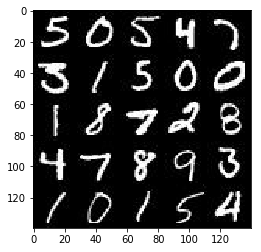

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

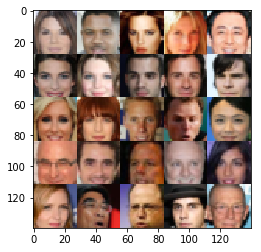

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0036... Generator Loss: 9.3819
Epoch 1/2... Discriminator Loss: 0.3623... Generator Loss: 3.9552
Epoch 1/2... Discriminator Loss: 0.3946... Generator Loss: 2.0410
Epoch 1/2... Discriminator Loss: 0.0608... Generator Loss: 3.8524
Epoch 1/2... Discriminator Loss: 1.5631... Generator Loss: 0.3196
Epoch 1/2... Discriminator Loss: 0.8050... Generator Loss: 3.4298
Epoch 1/2... Discriminator Loss: 0.3483... Generator Loss: 2.3793
Epoch 1/2... Discriminator Loss: 0.2773... Generator Loss: 2.5401
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 0.2215... Generator Loss: 3.6884


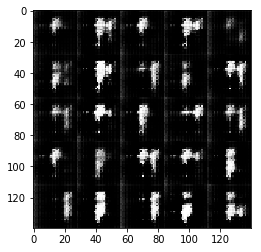

Epoch 1/2... Discriminator Loss: 0.5601... Generator Loss: 8.6329
Epoch 1/2... Discriminator Loss: 0.4698... Generator Loss: 2.0545
Epoch 1/2... Discriminator Loss: 0.6061... Generator Loss: 3.9258
Epoch 1/2... Discriminator Loss: 0.3202... Generator Loss: 3.2616
Epoch 1/2... Discriminator Loss: 0.6800... Generator Loss: 1.0268
Epoch 1/2... Discriminator Loss: 0.4415... Generator Loss: 2.2492
Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 1.1149
Epoch 1/2... Discriminator Loss: 0.3314... Generator Loss: 2.9201
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 7.5689
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.3850


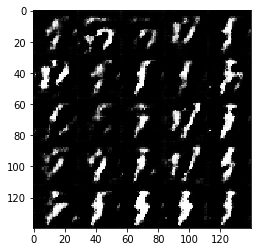

Epoch 1/2... Discriminator Loss: 0.5187... Generator Loss: 2.5077
Epoch 1/2... Discriminator Loss: 0.4691... Generator Loss: 3.5950
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 2.4276
Epoch 1/2... Discriminator Loss: 0.3924... Generator Loss: 3.4421
Epoch 1/2... Discriminator Loss: 0.3938... Generator Loss: 2.0543
Epoch 1/2... Discriminator Loss: 0.7717... Generator Loss: 2.6244
Epoch 1/2... Discriminator Loss: 0.4561... Generator Loss: 1.6420
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 1.0157
Epoch 1/2... Discriminator Loss: 0.5502... Generator Loss: 2.0555
Epoch 1/2... Discriminator Loss: 0.5192... Generator Loss: 1.5862


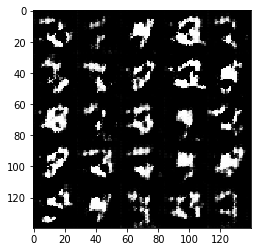

Epoch 1/2... Discriminator Loss: 0.3600... Generator Loss: 3.6692
Epoch 1/2... Discriminator Loss: 0.5588... Generator Loss: 1.9939
Epoch 1/2... Discriminator Loss: 0.6964... Generator Loss: 4.8941
Epoch 1/2... Discriminator Loss: 1.6793... Generator Loss: 0.3745
Epoch 1/2... Discriminator Loss: 1.1054... Generator Loss: 1.0270
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.8871
Epoch 1/2... Discriminator Loss: 1.1968... Generator Loss: 0.6557
Epoch 1/2... Discriminator Loss: 0.5912... Generator Loss: 1.5354
Epoch 1/2... Discriminator Loss: 0.8800... Generator Loss: 2.6321
Epoch 1/2... Discriminator Loss: 0.6532... Generator Loss: 1.4036


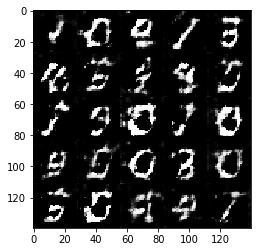

Epoch 1/2... Discriminator Loss: 0.6479... Generator Loss: 1.6868
Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 1.0717
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 1.1454
Epoch 1/2... Discriminator Loss: 1.2632... Generator Loss: 2.3470
Epoch 1/2... Discriminator Loss: 1.0082... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 1.4451... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.6336
Epoch 1/2... Discriminator Loss: 0.8242... Generator Loss: 1.2019
Epoch 1/2... Discriminator Loss: 1.1441... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 0.9024


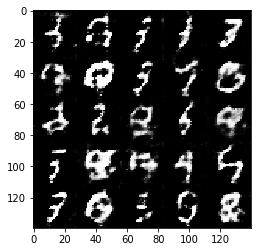

Epoch 1/2... Discriminator Loss: 0.8146... Generator Loss: 2.2027
Epoch 1/2... Discriminator Loss: 0.7556... Generator Loss: 0.9388
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 1.2859
Epoch 1/2... Discriminator Loss: 1.9613... Generator Loss: 3.9253
Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 1.0970
Epoch 1/2... Discriminator Loss: 0.8765... Generator Loss: 1.2179
Epoch 1/2... Discriminator Loss: 1.5043... Generator Loss: 0.4141
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 0.6455
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 1.2256
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 3.0180


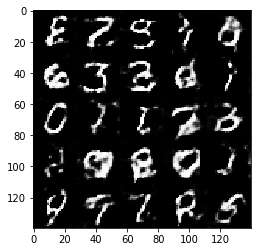

Epoch 1/2... Discriminator Loss: 0.7415... Generator Loss: 1.5011
Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 1.0699
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 0.6547... Generator Loss: 1.1276
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 1.4205
Epoch 1/2... Discriminator Loss: 0.7077... Generator Loss: 1.7884
Epoch 1/2... Discriminator Loss: 0.7830... Generator Loss: 1.6152
Epoch 1/2... Discriminator Loss: 2.2361... Generator Loss: 0.2209
Epoch 1/2... Discriminator Loss: 0.7417... Generator Loss: 1.4990
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 1.0987


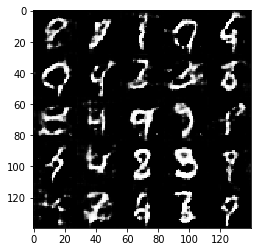

Epoch 1/2... Discriminator Loss: 0.7178... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 0.7815... Generator Loss: 2.3336
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 0.9043
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 0.7312... Generator Loss: 1.8379
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 2.5157
Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 1.8877
Epoch 1/2... Discriminator Loss: 1.5462... Generator Loss: 0.4259
Epoch 1/2... Discriminator Loss: 0.6754... Generator Loss: 1.5985
Epoch 1/2... Discriminator Loss: 1.6030... Generator Loss: 2.8213


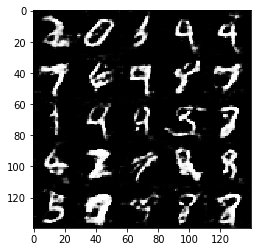

Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 1.5217
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 0.9640
Epoch 1/2... Discriminator Loss: 1.0091... Generator Loss: 2.2635
Epoch 1/2... Discriminator Loss: 2.0431... Generator Loss: 0.2533
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 1.0907
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.5380
Epoch 1/2... Discriminator Loss: 1.0386... Generator Loss: 0.7302
Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.4642
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 1.4789
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.4828


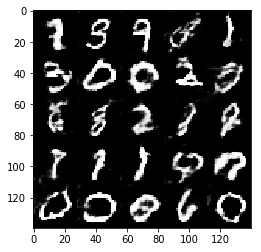

Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 2.3751
Epoch 1/2... Discriminator Loss: 1.0866... Generator Loss: 1.2061
Epoch 1/2... Discriminator Loss: 0.8455... Generator Loss: 0.9483
Epoch 2/2... Discriminator Loss: 0.9725... Generator Loss: 1.7753
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.5022
Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 1.4319
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 1.3637
Epoch 2/2... Discriminator Loss: 0.7341... Generator Loss: 1.1915
Epoch 2/2... Discriminator Loss: 2.1302... Generator Loss: 4.2489
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 0.9445


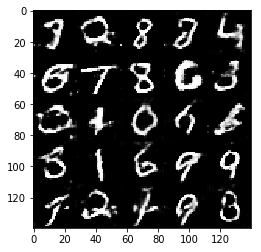

Epoch 2/2... Discriminator Loss: 0.6998... Generator Loss: 1.5315
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 0.5127
Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 0.8961
Epoch 2/2... Discriminator Loss: 1.7438... Generator Loss: 0.2900
Epoch 2/2... Discriminator Loss: 0.7184... Generator Loss: 1.3122
Epoch 2/2... Discriminator Loss: 0.8928... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 1.5408
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 1.9259
Epoch 2/2... Discriminator Loss: 1.5548... Generator Loss: 0.3590
Epoch 2/2... Discriminator Loss: 1.0021... Generator Loss: 2.0668


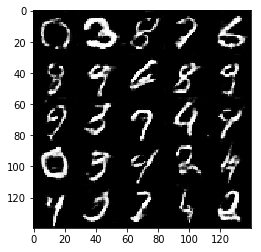

Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 0.6815
Epoch 2/2... Discriminator Loss: 1.6290... Generator Loss: 0.3262
Epoch 2/2... Discriminator Loss: 1.4006... Generator Loss: 0.4482
Epoch 2/2... Discriminator Loss: 0.9119... Generator Loss: 1.1314
Epoch 2/2... Discriminator Loss: 0.9157... Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 1.2433
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 0.8218
Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 1.4890
Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 2.4216
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 0.6835


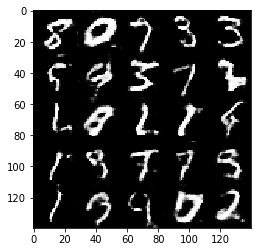

Epoch 2/2... Discriminator Loss: 0.9153... Generator Loss: 1.9861
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 1.0938... Generator Loss: 0.5980
Epoch 2/2... Discriminator Loss: 2.5879... Generator Loss: 0.2077
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 1.2262
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.5933
Epoch 2/2... Discriminator Loss: 1.1114... Generator Loss: 0.9915
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 0.4184
Epoch 2/2... Discriminator Loss: 1.2658... Generator Loss: 0.5036


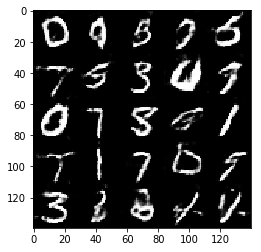

Epoch 2/2... Discriminator Loss: 1.4985... Generator Loss: 0.4600
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 2.1127
Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 2.0003
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 0.6884
Epoch 2/2... Discriminator Loss: 0.9245... Generator Loss: 1.0785
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 0.8450
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 0.7544
Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 0.5699
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 2.0081


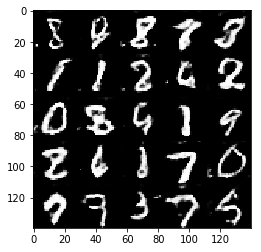

Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.4270
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.4820
Epoch 2/2... Discriminator Loss: 0.9717... Generator Loss: 0.8361
Epoch 2/2... Discriminator Loss: 1.4943... Generator Loss: 0.4462
Epoch 2/2... Discriminator Loss: 1.2976... Generator Loss: 0.5075
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 3.9905
Epoch 2/2... Discriminator Loss: 5.9899... Generator Loss: 7.1924
Epoch 2/2... Discriminator Loss: 0.9397... Generator Loss: 0.9986
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.5456
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 0.6578


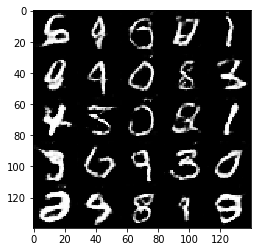

Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 0.5313
Epoch 2/2... Discriminator Loss: 0.3733... Generator Loss: 1.5850
Epoch 2/2... Discriminator Loss: 2.0906... Generator Loss: 3.9855
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 0.7217
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 0.9593
Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.5650
Epoch 2/2... Discriminator Loss: 0.8753... Generator Loss: 1.5844
Epoch 2/2... Discriminator Loss: 1.1664... Generator Loss: 0.5383
Epoch 2/2... Discriminator Loss: 1.4472... Generator Loss: 2.3263


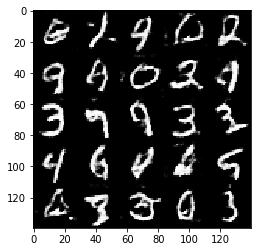

Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 1.1585
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.7119
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 0.7580
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.5577
Epoch 2/2... Discriminator Loss: 0.9087... Generator Loss: 2.0436
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 1.7487... Generator Loss: 0.3559
Epoch 2/2... Discriminator Loss: 0.7719... Generator Loss: 1.0422
Epoch 2/2... Discriminator Loss: 0.5309... Generator Loss: 1.6635
Epoch 2/2... Discriminator Loss: 1.4661... Generator Loss: 0.6499


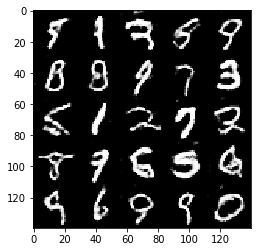

Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 2.0292
Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 0.4790
Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 0.8589
Epoch 2/2... Discriminator Loss: 0.9617... Generator Loss: 1.3142
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 2.8975
Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 2.4303
Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 0.6612
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.1361
Epoch 2/2... Discriminator Loss: 0.8034... Generator Loss: 0.9274
Epoch 2/2... Discriminator Loss: 1.0113... Generator Loss: 0.8392


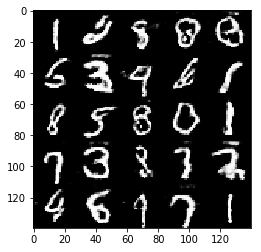

Epoch 2/2... Discriminator Loss: 0.6557... Generator Loss: 1.6101
Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 2.5182
Epoch 2/2... Discriminator Loss: 0.8307... Generator Loss: 1.1337
Epoch 2/2... Discriminator Loss: 1.1139... Generator Loss: 0.5855
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 1.3055
Epoch 2/2... Discriminator Loss: 0.6397... Generator Loss: 1.6667
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 1.0300


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1736... Generator Loss: 7.8675
Epoch 1/1... Discriminator Loss: 0.5002... Generator Loss: 4.5171
Epoch 1/1... Discriminator Loss: 2.7882... Generator Loss: 9.3158
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 1.6973
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 3.0111
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 0.4898... Generator Loss: 3.4872
Epoch 1/1... Discriminator Loss: 0.2128... Generator Loss: 2.2254
Epoch 1/1... Discriminator Loss: 0.1345... Generator Loss: 3.0510
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 2.5013


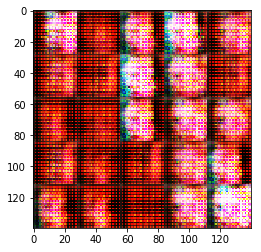

Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 1.6648
Epoch 1/1... Discriminator Loss: 0.3385... Generator Loss: 2.1404
Epoch 1/1... Discriminator Loss: 4.2457... Generator Loss: 5.3334
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.3127
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 4.7948
Epoch 1/1... Discriminator Loss: 0.4988... Generator Loss: 1.9581
Epoch 1/1... Discriminator Loss: 2.2270... Generator Loss: 3.0167
Epoch 1/1... Discriminator Loss: 1.9117... Generator Loss: 2.4960


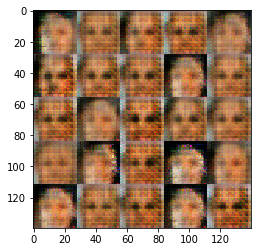

Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.4192
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 1.9569
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 4.7528
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.6437... Generator Loss: 0.3597
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 1.3572


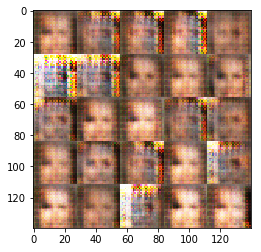

Epoch 1/1... Discriminator Loss: 1.8484... Generator Loss: 2.6007
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.3792
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.3469
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.4030


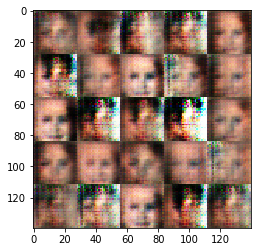

Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 1.5942
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 2.4038
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 2.2077
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.3794


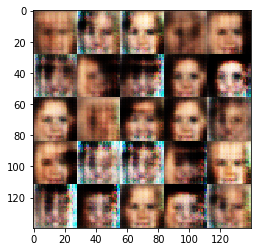

Epoch 1/1... Discriminator Loss: 1.8179... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 2.2144
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.4411
Epoch 1/1... Discriminator Loss: 1.7823... Generator Loss: 0.2294
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.1942


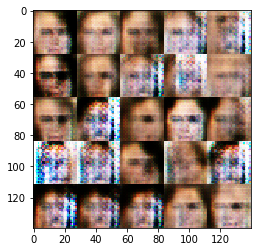

Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.5843
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.4700
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 0.8574


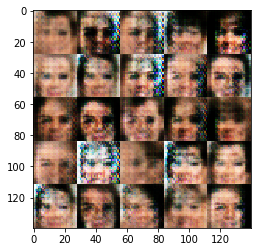

Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 2.2417
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.5349
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 2.5095
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 1.8479


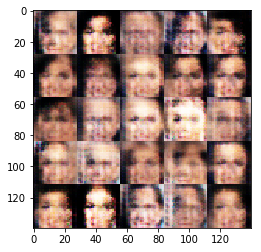

Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 3.0589
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 3.4945
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.7204
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.7277
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 0.9528


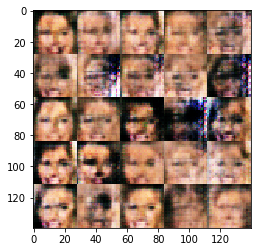

Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 1.9350
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.2461
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.7937... Generator Loss: 2.2390
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 1.5867
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.8007


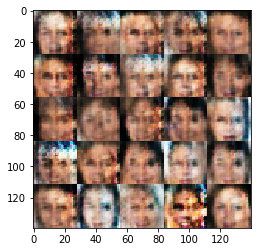

Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 2.2008... Generator Loss: 0.1768
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 3.0989
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.8188
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.6021
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.6537


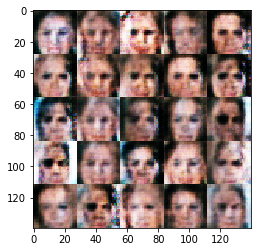

Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.4857
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 1.5762
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.4369
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 2.1336
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 2.2155
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 0.8664


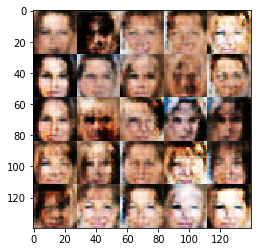

Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 1.9920
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 2.1247
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.5537
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 0.6728... Generator Loss: 1.2892
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.4119
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.5996
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.2932


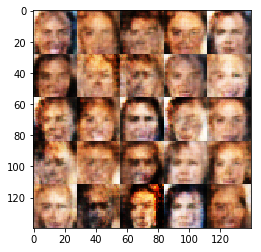

Epoch 1/1... Discriminator Loss: 0.7444... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.3603
Epoch 1/1... Discriminator Loss: 2.7344... Generator Loss: 0.0980
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.4078
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.3205
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 1.7363
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 0.7788


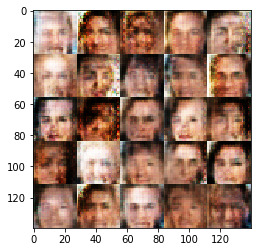

Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 2.0396... Generator Loss: 2.6431
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.1080
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 0.9109


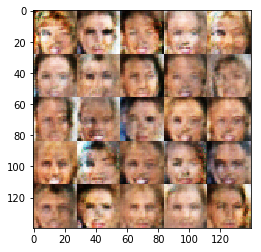

Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.2380
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 1.6144
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.6195
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 1.7403


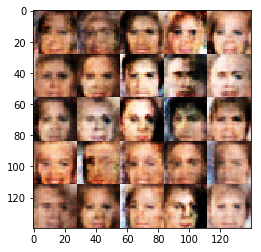

Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 1.6145
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.2948
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 1.3900
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 1.3639
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.3489


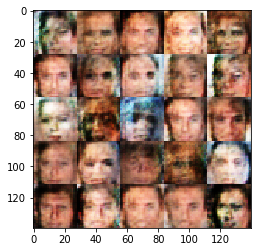

Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.7868... Generator Loss: 0.2759
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.6797


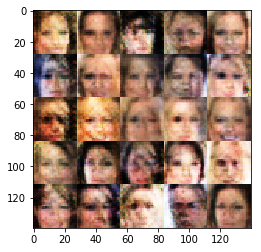

Epoch 1/1... Discriminator Loss: 1.8481... Generator Loss: 1.7541
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.3506
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 2.0881
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.5162
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.7282


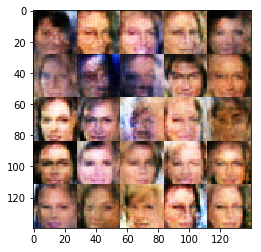

Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.8842
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.7402
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 3.8572... Generator Loss: 4.2289


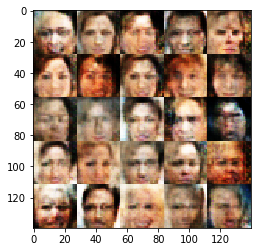

Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.2717
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 1.7445
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.1203
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.7492


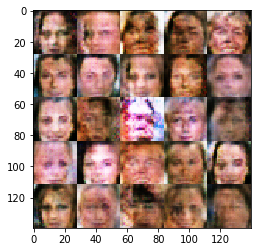

Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.4776
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.8540... Generator Loss: 2.1155
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 1.7973
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.5718


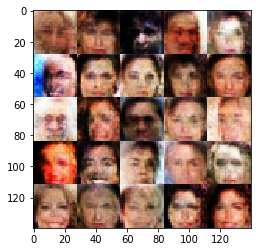

Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.4411
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 1.9366
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.6539


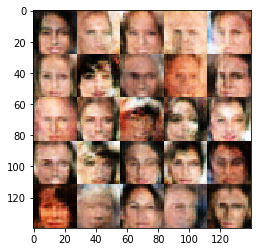

Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.8445... Generator Loss: 0.2839
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.5068
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 2.5708
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.1166
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.4596


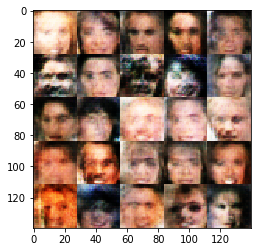

Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.3471
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.7446
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.1787


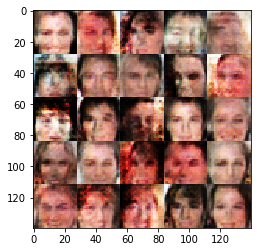

Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.4140
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.2074
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.8031


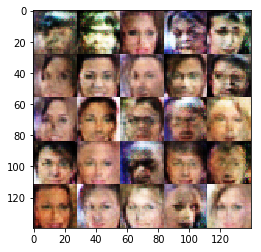

Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.3749
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 1.6073
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 2.2774
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.2202
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.9645


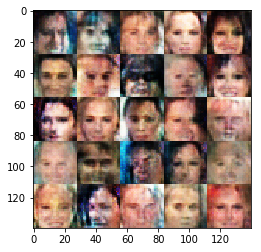

Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.3993
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 0.9701


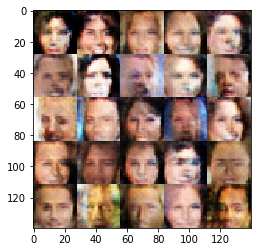

Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.2687
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 2.3556
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.2710
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.7400


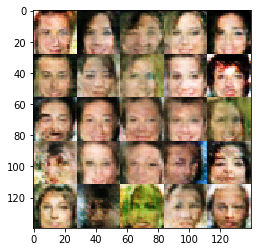

Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.4066
Epoch 1/1... Discriminator Loss: 2.2207... Generator Loss: 1.3018
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.7499


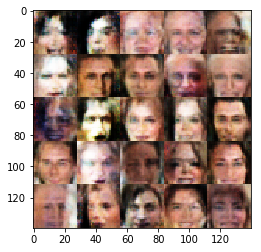

Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.1924
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 1.3586
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.9452
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.6178
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.6705


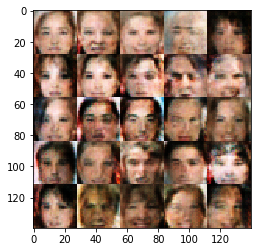

Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 1.9240... Generator Loss: 0.2274
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.8904... Generator Loss: 0.2303
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.8080


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.